In [1]:
import torch
from torchvision.models import ResNet
import torchvision.transforms as T
from time_shift_dataset import TimeShiftDataset
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from models import LinearEval, BaselineImagenet1K
from eval import eval

In [2]:
# Preparation
device = "cuda" if torch.cuda.is_available() else "cpu"
MODEL_NAME = 'backbone_time_shift_EP_30_BS_80_PRX_30_LAMBDA_0.001'
backbone: ResNet = torch.load(f'./models/{MODEL_NAME}.pth').to(device)

transform = T.Compose([
    T.Resize(128),
    T.ToTensor(),
    T.Grayscale()
])

train_dataset = TimeShiftDataset('../datasets/hand', transform=transform, train=True)
test_dataset = TimeShiftDataset('../datasets/hand', transform=transform, train=False)

# Exploiting temporal coherence in video for self-supervised representation learning

## 1. Linear classification
In this experiment we are training a linear classifier on top on the produced representations to evaluate their performance.

## 2. Fine tuning performance
In this experiment we are finetuning the classifiers on subsets of the training data to evaluate how useful our method is for pretraining, in comparison to our baseline which is pretrained on imagenet1k. 

  0%|          | 0/20 [00:00<?, ?it/s]/home/yasin/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(


Text(0, 0.5, 'Test error')

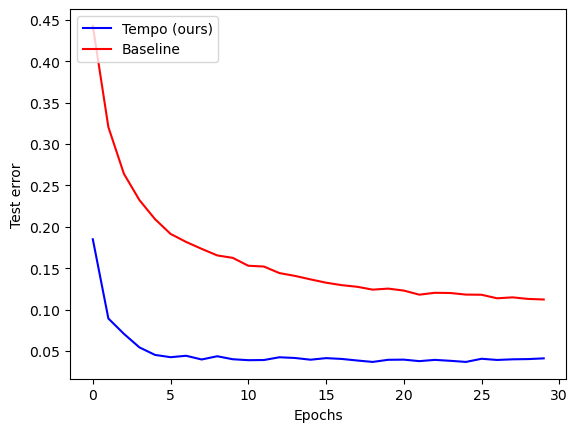

In [3]:
lss_eval, errs_eval = [], []
lss_bl, errs_bl = [], []
for i in tqdm(range(20), leave=False):
    ss_indices = np.random.choice(len(train_dataset), 200, replace=False)
    ss_train = torch.utils.data.Subset(train_dataset, ss_indices)

    train_dataloader = torch.utils.data.DataLoader(
        ss_train, # train_dataset,
        batch_size=32,
        shuffle=True,
        num_workers=8,
    )

    test_dataloader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=32,
        shuffle=True,
        num_workers=8,
    )

    eval_model = LinearEval(backbone=backbone).to(device)
    baseline = BaselineImagenet1K().to(device)

    losses_eval, errors_eval = eval(eval_model, train_dataset, test_dataset, train_dataloader, test_dataloader)
    losses_bl, errors_bl = eval(baseline, train_dataset, test_dataset, train_dataloader, test_dataloader)

    lss_eval.append(losses_eval)
    errs_eval.append(errors_eval)
    lss_bl.append(losses_bl)
    errs_bl.append(errors_bl)

errs_eval = np.array(errs_eval)
errs_bl = np.array(errs_bl)

plt.plot(np.arange(30), errs_eval.mean(axis=0), '-b', label='Tempo (ours)')
plt.plot(np.arange(30), errs_bl.mean(axis=0), '-r', label='Baseline')
plt.legend(loc="upper left")
plt.xlabel('Epochs')
plt.ylabel('Test error')